In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
# class AGCODataset(Dataset):
#     def __init__(self, good_image_dir, synthetic_image_dir, transform=None):
#         self.good_image_dir = good_image_dir
#         self.synthetic_image_dir = synthetic_image_dir
#         self.transform = transform
#         self.data = []

#         # Load good images (label 0, no mask)
#         for img_file in os.listdir(good_image_dir):
#             img_path = os.path.join(good_image_dir, img_file)
#             if os.path.isfile(img_path):
#                 self.data.append((img_path, None, 0))  # No mask for good images

#         # Load synthetic anomaly images and their masks (label 1)
#         for img_file in os.listdir(synthetic_image_dir):
#             if '_anomaly' in img_file:
#                 img_path = os.path.join(synthetic_image_dir, img_file)
#                 mask_file = img_file.replace('_anomaly', '_mask')
#                 mask_path = os.path.join(synthetic_image_dir, mask_file)
#                 if os.path.isfile(img_path) and os.path.isfile(mask_path):
#                     self.data.append((img_path, mask_path, 1))  # Label 1 for anomalies

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_path, mask_path, label = self.data[idx]
#         image = Image.open(img_path).convert('RGB')
#         mask = Image.open(mask_path).convert('L') if mask_path else None

#         if self.transform:
#             image = self.transform(image)
#             if mask:
#                 mask = self.transform(mask)  # Apply the same transformation to the mask
#             else:
#                 mask = torch.zeros((1, 256, 256))  # Dummy mask for "good" images

#         return image, mask, label

In [5]:
class AGCODataset(Dataset):
    def __init__(self, good_image_dir, synthetic_image_dir, transform=None):
        self.good_image_dir = good_image_dir
        self.synthetic_image_dir = synthetic_image_dir
        self.transform = transform
        self.data = []

        # Load good images (label 0, no mask)
        for img_file in os.listdir(good_image_dir):
            img_path = os.path.join(good_image_dir, img_file)
            if os.path.isfile(img_path):
                self.data.append((img_path, None, 0))  # No mask for good images

        # Load synthetic anomaly images and their masks (label 1)
        for img_file in os.listdir(synthetic_image_dir):
            if img_file.endswith('.png') and '_mask' not in img_file:
                img_path = os.path.join(synthetic_image_dir, img_file)
                # Replaced .png with _mask.png
                mask_file = img_file.replace('.png', '_mask.png') 
                mask_path = os.path.join(synthetic_image_dir, mask_file)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    self.data.append((img_path, mask_path, 1))  # Label 1 for anomalies

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        # For anomaly images, load the mask
        if mask_path:
            mask = Image.open(mask_path).convert('L')
        else:
            # For good images, use a dummy mask (black image)
            mask = Image.new('L', image.size, 0)  # Dummy mask, black (0)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # Apply the same transformation to the mask

        return image, mask, label


In [6]:
# Function to visualize a few random samples from the dataset
def visualize_samples(dataset, num_samples=5):
    # Randomly select 'num_samples' indices
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Set up the plot with enough space for 'num_samples' images and masks
    plt.figure(figsize=(15, 5 * num_samples))  # Adjust the figure size to fit images
    
    for i, idx in enumerate(indices):
        # Get the image, mask, and label
        image, mask, label = dataset[idx]
        
        # Convert image and mask tensors to numpy arrays for visualization
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        
        # Squeeze mask to remove singleton dimension (1, H, W) -> (H, W)
        mask = mask.squeeze(0).numpy()  # Convert mask tensor to numpy array and remove the channel
        
        # Create subplots for each image and its corresponding mask
        plt.subplot(num_samples, 2, 2 * i + 1)  # Image on the left
        plt.imshow(image)
        plt.title(f'Image {i+1}')
        plt.axis('off')  # Hide axes
        
        plt.subplot(num_samples, 2, 2 * i + 2)  # Mask on the right
        plt.imshow(mask, cmap='gray')  # Display the mask in grayscale
        if label == 1:
            plt.imshow(mask, alpha=0.5, cmap='jet')  # Apply transparency for anomalies
        plt.title(f'Mask {i+1}')
        plt.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

In [7]:
# Instantiate the dataset
normal_dir = "../../datasets/agco_front/normal"
# anomaly_dir = "../../datasets/agco_front/synthetic_normal_clone_with_mask/"
anomaly_dir = "../../datasets/agco_testing_dataset/mask2/"

In [8]:
dataset = AGCODataset(normal_dir, anomaly_dir, transform=transform)

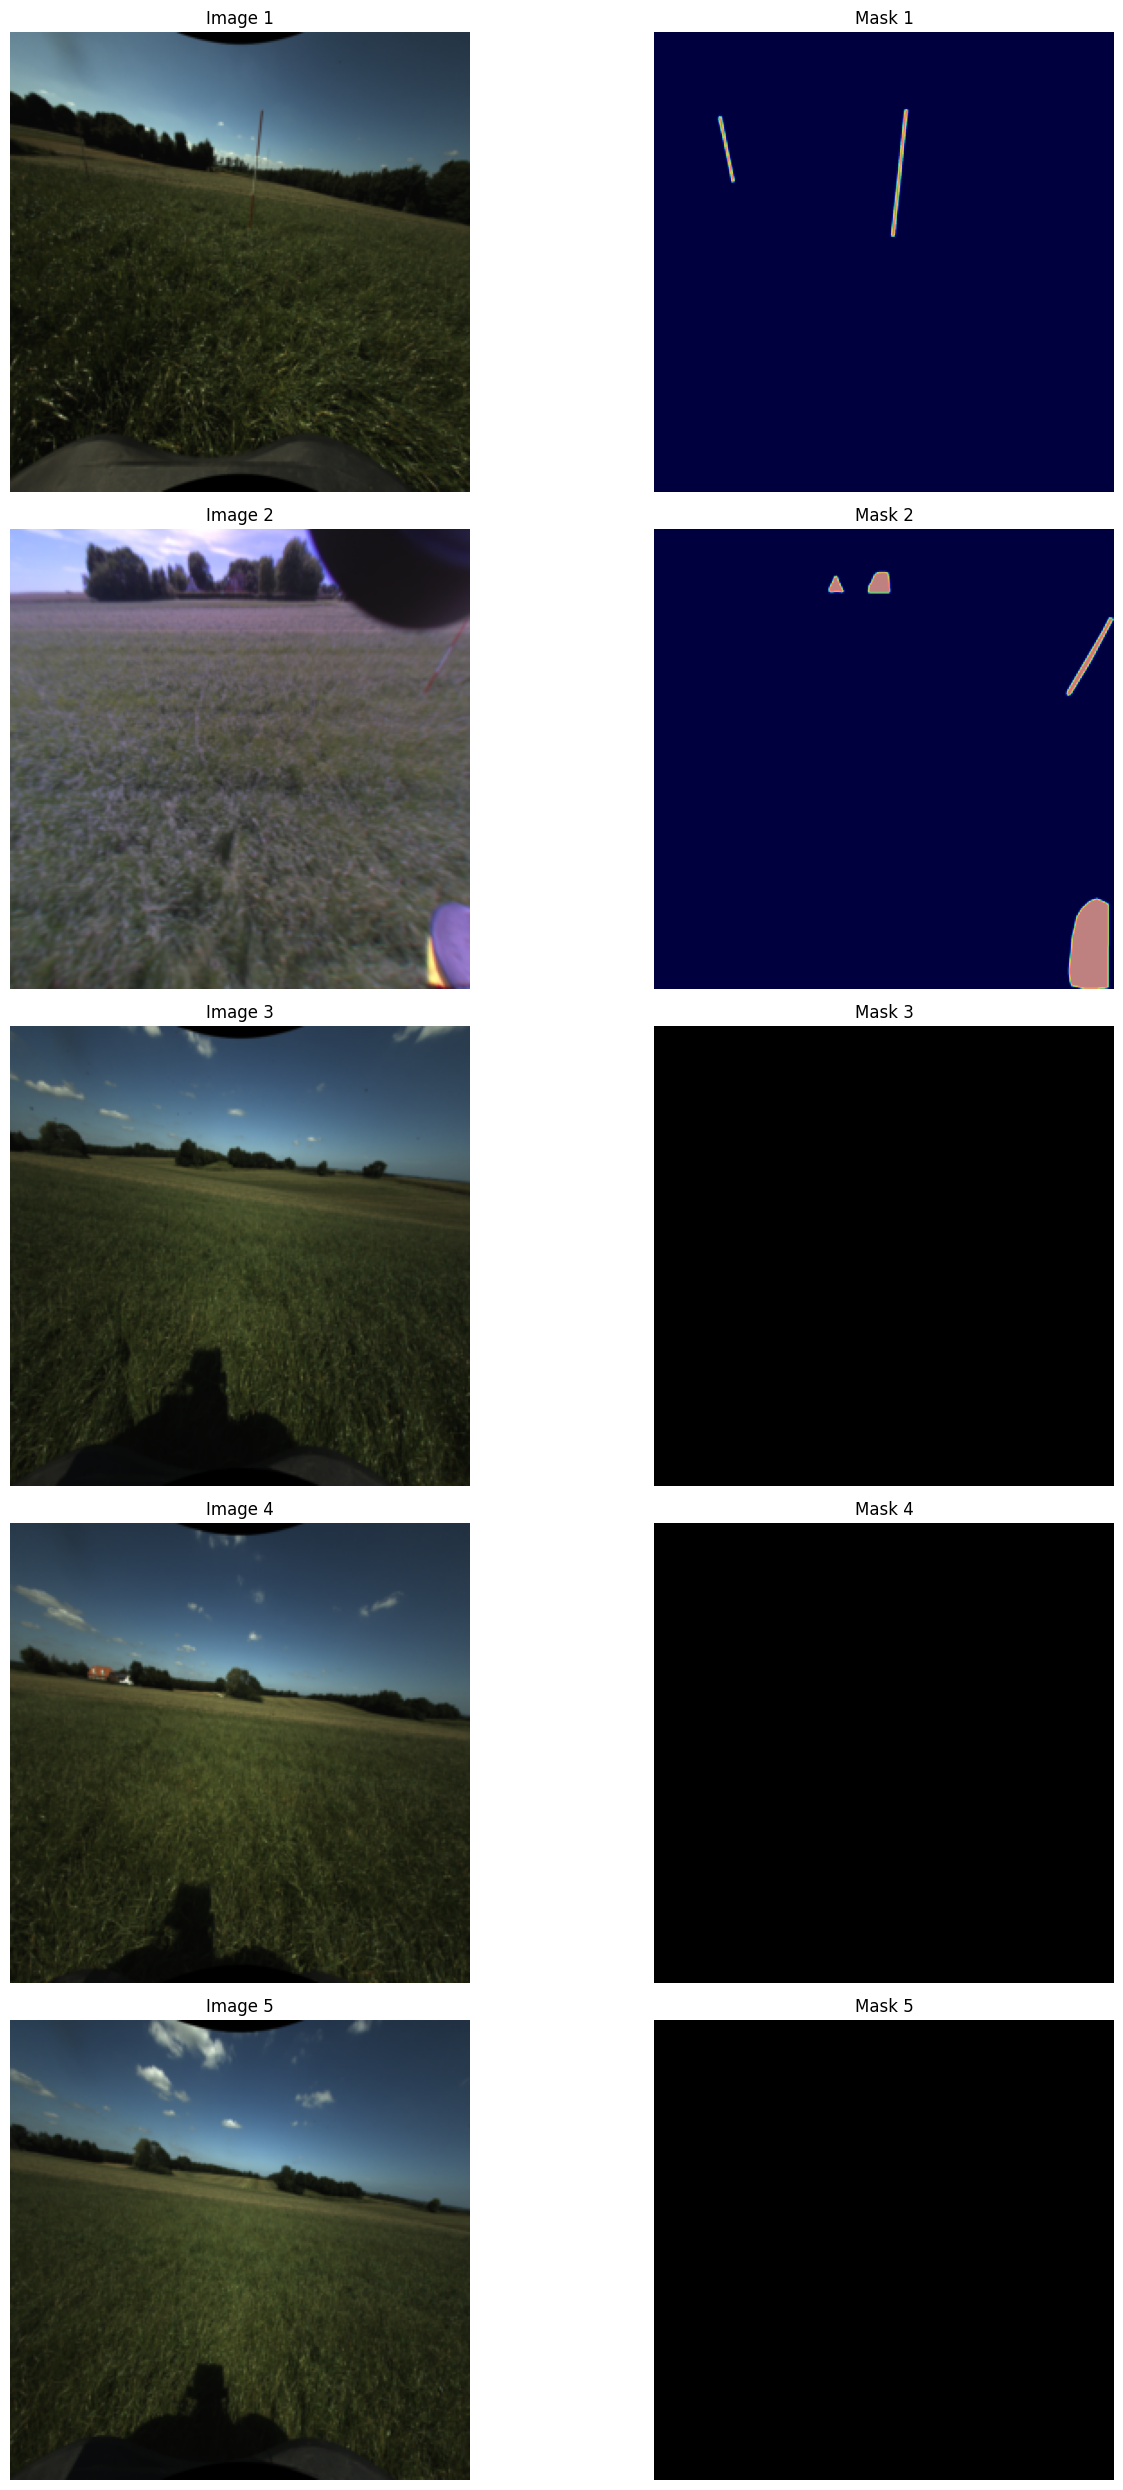

In [9]:
visualize_samples(dataset, num_samples=5)

In [10]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

In [11]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
for images, masks, _ in dataloader:
    print(images.shape, masks.shape) 
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 1954
Validation set size: 652


In [15]:
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.2)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


        # Note: decrease the complexity on the model
        # Note: train more epochs
        
        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

        # Classification layer for image-level classification
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, 1)  # Binary classification (good vs anomaly)
        )

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        decoded = self.uplayer1(x)
        decoded = self.uplayer2(decoded)
        decoded = self.uplayer3(decoded)

        # Upsample
        decoded = self.upsample(decoded)

        # Final convolution
        decoded = self.convtranspose1(decoded)

        # Final activation (here it's Identity)
        decoded = self.final_activation(decoded)

        # Image-level classification
        x = torch.mean(x, dim=[2, 3])  # Global Average Pooling
        class_output = self.classifier(x)
        class_output = torch.sigmoid(class_output)

        return decoded, class_output

In [16]:
model = ResNetEncDec().to(device)
# model

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for pixel-wise classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# # Check what each batch from the dataloader looks like
# for batch in train_loader:
#     print(f"Batch output: {batch}")
#     break  # Just check the first batch

In [97]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for images, masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        decoded, _ = model(images)  # Get only the pixel-level output for segmentation
        decoded = torch.sigmoid(decoded)  # Ensure output is in [0, 1] range

        # Compute loss
        loss = criterion(decoded, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            # Forward pass
            val_decoded, _ = model(val_images)
            val_decoded = torch.sigmoid(val_decoded)  # Sigmoid activation for BCE

            # Compute validation loss
            val_loss = criterion(val_decoded, val_masks)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"./best_model_pixel_level_testcase_1.pth")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Epoch [1/10] - Train Loss: 0.5114, Val Loss: 0.3700
Best model saved with validation loss: 0.3700


Epoch [2/10] - Train Loss: 0.2924, Val Loss: 0.2248
Best model saved with validation loss: 0.2248


Epoch [3/10] - Train Loss: 0.1834, Val Loss: 0.1485
Best model saved with validation loss: 0.1485


Epoch [4/10] - Train Loss: 0.1252, Val Loss: 0.1034
Best model saved with validation loss: 0.1034


Epoch [5/10] - Train Loss: 0.0919, Val Loss: 0.0745
Best model saved with validation loss: 0.0745


Epoch [6/10] - Train Loss: 0.0685, Val Loss: 0.0600
Best model saved with validation loss: 0.0600


Epoch [7/10] - Train Loss: 0.0541, Val Loss: 0.0485
Best model saved with validation loss: 0.0485


Epoch [8/10] - Train Loss: 0.0443, Val Loss: 0.0403
Best model saved with validation loss: 0.0403


Epoch [9/10] - Train Loss: 0.0370, Val Loss: 0.0347
Best model saved with validation loss: 0.0347


Epoch [10/10] - Train Loss: 0.0318, Val Loss: 0.0303
Best model saved with validation loss: 0.0303


### Testing

In [33]:
def visualize_predictions(model, dataset, device, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    
    # Select random indices from the validation dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            # Get the image and mask from the dataset
            image, true_mask, _ = dataset[idx]
            
            # Move the image to the device and add a batch dimension
            image = image.to(device).unsqueeze(0)
            
            # Get model prediction
            pred_mask, _ = model(image)
            pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid to get probabilities
            
            # Move tensors to CPU and remove batch dimension for visualization
            image = image.squeeze().cpu().permute(1, 2, 0)
            true_mask = true_mask.squeeze().cpu()
            pred_mask = pred_mask.squeeze().cpu()
            
            # Plot original image, true mask, and predicted mask
            axs[i, 0].imshow(image)
            axs[i, 0].set_title("Input Image")
            axs[i, 0].axis("off")

            axs[i, 1].imshow(true_mask, cmap="gray")
            axs[i, 1].set_title("True Mask")
            axs[i, 1].axis("off")

            axs[i, 2].imshow(pred_mask, cmap="gray")
            axs[i, 2].set_title("Predicted Mask")
            axs[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

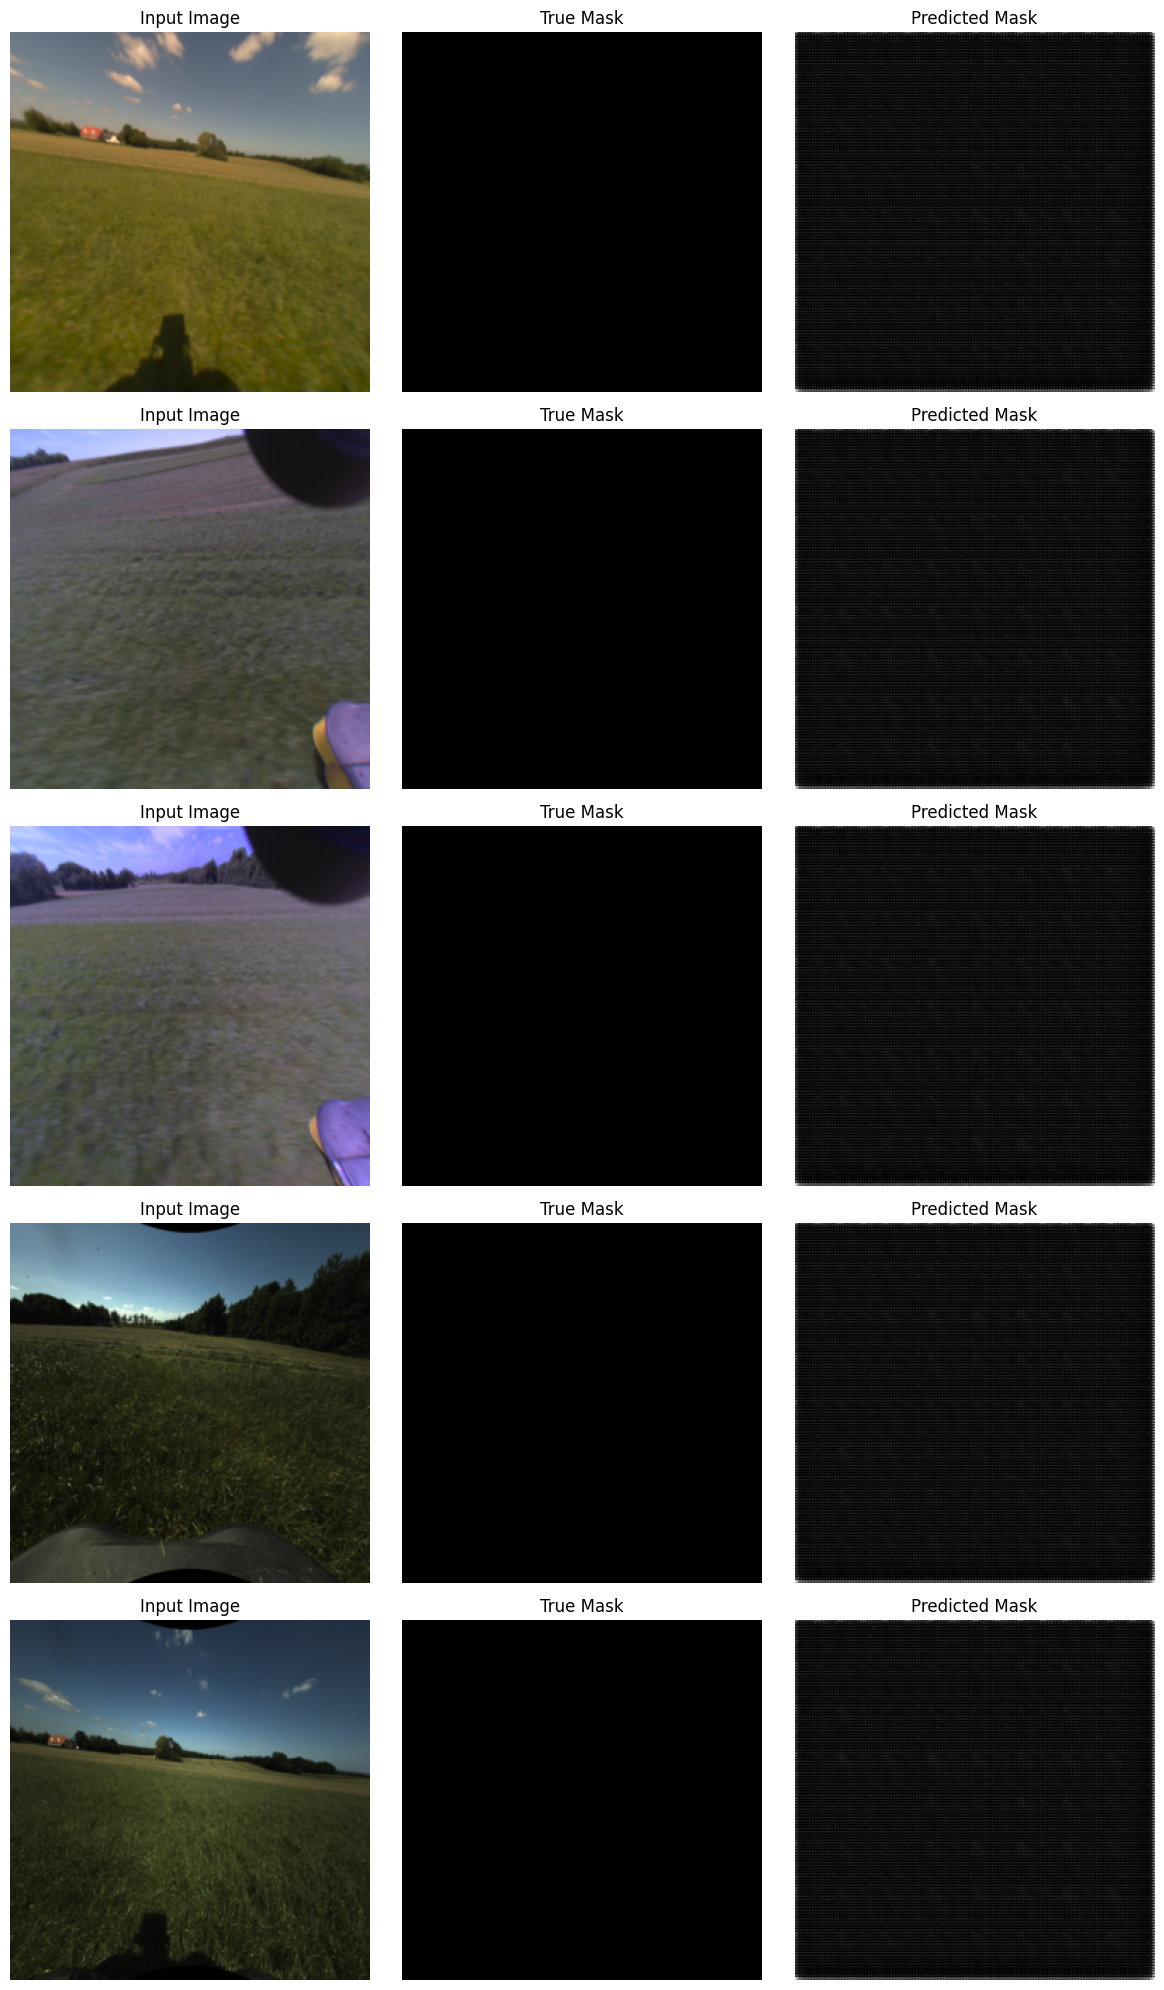

In [35]:
model.load_state_dict(torch.load("./best_model_pixel_level_testcase_1.pth"))
model.to(device)

visualize_predictions(model, val_dataset, device)

## on predicted mask use gaussian filter or edge removal (la plassian)

In [36]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on an image and mask.
        """
        self.root_dir = root_dir
        self.transform = transform
        # List all image files in the directory
        self.images = [f for f in os.listdir(root_dir) if not f.endswith('_mask.png')]
        # Create the corresponding mask filenames by appending '_mask' before the extension
        self.masks = [f.replace('.png', '_mask.png') for f in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image and mask
        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.root_dir, self.masks[idx])

        image = Image.open(img_name).convert('RGB')  # Convert image to RGB
        mask = Image.open(mask_name).convert('L')   # Convert mask to grayscale (L mode)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, self.images[idx]

In [25]:
def is_anomaly(mask):
    """
    Determines if the mask contains any white pixels (anomaly detection).
    
    Args:
    - mask: The binary mask (numpy array or tensor) to check for anomalies.
    
    Returns:
    - bool: True if the mask contains any white pixels (anomaly), False otherwise.
    """
    mask_np = np.array(mask)  # Ensure the mask is a numpy array
    white_pixels = np.sum(mask_np > 0)  # Count non-zero pixels as white
    
    # If any white pixels are found, classify as anomaly
    if white_pixels > 0:
        print("Anomaly Detected")
        return True  # Anomaly detected
    else:
        print("No Anomaly Detected")
        return False  # Normal


In [26]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []  # Store true labels for the images
    y_pred = []  # Store predicted labels for the images

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images = images.to(device)
            outputs = model(images)  # Get model predictions

            # If outputs is a tuple, extract the actual prediction
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Assuming the first element is the prediction

            # Loop through each image in the batch
            for i in range(images.shape[0]):  # Loop through each image in the batch
                true_mask = masks[i].cpu().numpy()  # Ground truth mask
                pred_mask = outputs[i].cpu().numpy()  # Predicted mask
                
                # Determine true label (Normal=0, Anomaly=1) based on the ground truth mask
                true_label = is_anomaly(true_mask)

                # Determine predicted label (Normal=0, Anomaly=1) based on the predicted mask
                pred_label = is_anomaly(pred_mask)

                # Append labels for the entire image
                y_true.append(true_label)
                y_pred.append(pred_label)

    return y_true, y_pred


In [27]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Normal', 'Anomaly']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [28]:
# Define transformation and test set path
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
testset_path = "../../datasets/agco_testing_dataset/mask2/"
test_dataset = TestDataset(root_dir=testset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, masks, _ in test_loader:
#             images = images.to(device)
#             outputs = model(images)  # Get model predictions

#             # If outputs is a tuple, extract the actual prediction
#             if isinstance(outputs, tuple):
#                 outputs = outputs[0]  # Assuming the first element is the prediction

#             # Apply threshold to get binary prediction (normal or anomaly)
#             preds = (outputs > 0.5).float()  # Pixel-wise thresholding (binary classification)

#             # Loop through each mask and prediction pair
#             for mask, pred in zip(masks, preds):
#                 # Convert mask to binary based on white pixels (anomaly detection)
#                 true_label = is_anomaly(mask)  # Anomaly if white parts present
                
#                 # Flatten both the prediction and mask to 1D arrays for comparison
#                 pred_flat = pred.view(-1).cpu().numpy()
#                 mask_flat = np.array(mask).flatten() > 0  # Mask threshold to identify white areas (anomalies)

#                 # Convert mask to binary anomaly label (True/False)
#                 true_label_flat = np.full_like(pred_flat, true_label, dtype=bool)

#                 all_preds.extend(pred_flat)  # Add flattened prediction to list
#                 all_labels.extend(true_label_flat)  # Add flattened true label to list

#     return all_preds, all_labels

In [30]:
model.load_state_dict(torch.load("best_model_pixel_level_1.pth"))
model.to(device)

ResNetEncDec(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

Anomaly Detected
Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No Anomaly Detected
Anomaly Detected
No An

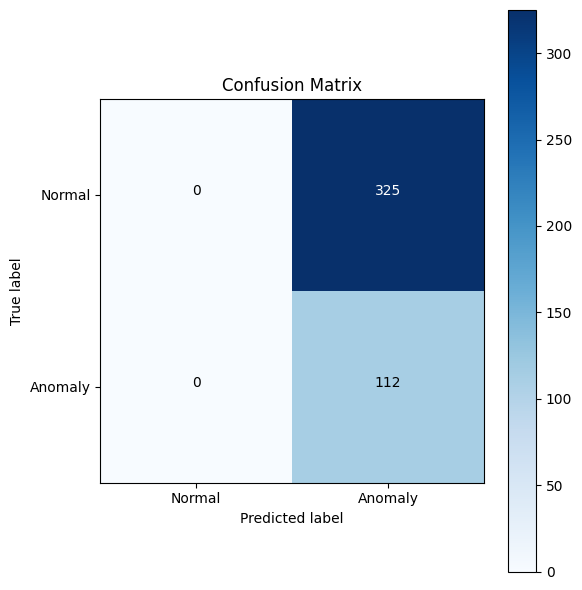

In [31]:
# Evaluate and plot confusion matrix
y_preds, y_true = evaluate_model(model, test_loader, device)
plot_confusion_matrix(y_true, y_preds)

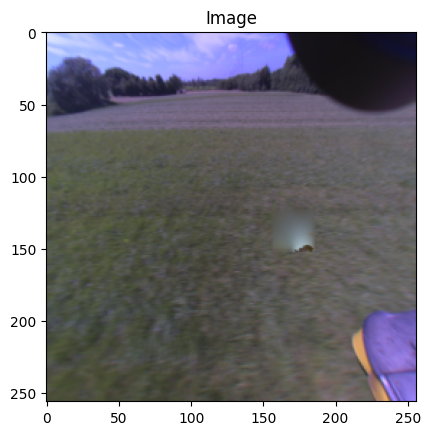

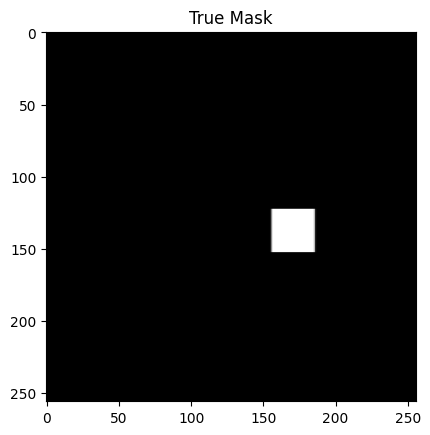

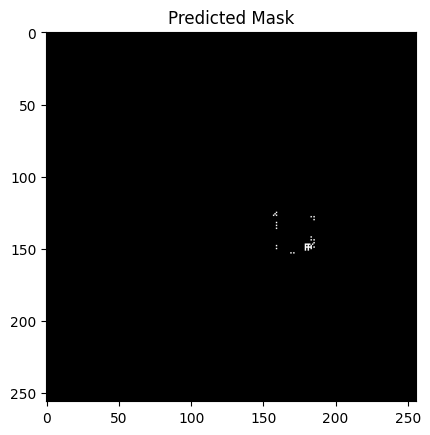

In [70]:
# Select a single sample from the test_loader for debugging
image, mask, _ = val_loader.dataset[103]  # Get the first sample
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Get the model's output
output = model(image)

# If output is a tuple, extract the first element (usually the predictions)
if isinstance(output, tuple):
    output = output[0]

# Apply sigmoid for probabilities if output is logits
output = torch.sigmoid(output)  # Apply sigmoid to get probabilities

# Visualize the image, true mask, and predicted mask
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # Show the image
plt.title("Image")
plt.show()

plt.imshow(mask.squeeze().cpu().numpy(), cmap='gray')  # Show the true mask
plt.title("True Mask")
plt.show()

# Detach the tensor, move it to CPU, and then convert it to numpy
output = output.detach().cpu().numpy()  # Detach from the computation graph and move to CPU

# Apply threshold to get the predicted mask (binary classification)
pred_mask = (output.squeeze() > 0.5)  # Apply threshold at 0.5

plt.imshow(pred_mask, cmap='gray')  # Show the predicted mask
plt.title("Predicted Mask")
plt.show()

In [83]:
def visualize_random_samples_with_anomalies(test_loader, model, device, num_samples=5):
    """
    Randomly visualize some samples from the test set along with their true labels and predicted labels.
    The function will also indicate if an anomaly was detected for each sample.
    
    Parameters:
    - test_loader: DataLoader for the test set.
    - model: The trained model for prediction.
    - device: The device to perform inference (CPU or GPU).
    - num_samples: Number of samples to visualize.
    """
    model.eval()  # Set the model to evaluation mode
    count = 0  # To keep track of the number of samples visualized
    
    # Randomly sample `num_samples` images from the test_loader
    indices = random.sample(range(len(test_loader.dataset)), num_samples)
    
    with torch.no_grad():
        for idx in indices:
            # Get the image and mask for this random sample
            image, mask, _ = test_loader.dataset[idx]  # Accessing the dataset directly to get the image and mask
            
            # Move the image to the device and add a batch dimension
            image = image.to(device).unsqueeze(0)
            
            # Get the model's predictions
            outputs = model(image)  # Model prediction

            # If outputs is a tuple, extract the first element (usually the predictions)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
                
            # Apply sigmoid for probabilities if output is logits
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Detach the tensor, move it to CPU, and then convert it to numpy
            output = outputs.detach().cpu().numpy()  # Detach from the computation graph and move to CPU
            
            # Apply threshold to get the predicted mask (binary classification)
            pred_mask = (output.squeeze() > 0.5)  # Apply threshold at 0.5

            # Convert to CPU and NumPy for visualization
            image = image.squeeze().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            mask = mask.squeeze().cpu().numpy()  # (H, W)
            pred_mask = pred_mask.squeeze()  # (H, W)

            # Determine the true label for the image based on the ground truth mask
            true_label = is_anomaly(mask)
            pred_label = is_anomaly(pred_mask)

            # Plot the image, true label, and predicted label
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            # Show the image (if it's RGB, it will display correctly)
            axes[0].imshow(image)
            axes[0].set_title(f"Sample {count + 1} - Image")
            axes[0].axis('off')

            # Show the true mask with its label
            axes[1].imshow(mask, cmap='gray')
            axes[1].set_title(f"True Label - {'Anomaly' if true_label else 'Normal'}")
            axes[1].axis('off')

            # Show the predicted mask with its label
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title(f"Predicted Label - {'Anomaly' if pred_label else 'Normal'}")
            axes[2].axis('off')

            # Indicate anomaly detection
            print(f"Sample {count + 1} - True Label: {'Anomaly' if true_label else 'Normal'}")
            print(f"Sample {count + 1} - Predicted Label: {'Anomaly' if pred_label else 'Normal'}")
            print("-" * 50)

            plt.show()
            count += 1

Anomaly Detected
Anomaly Detected
Sample 1 - True Label: Anomaly
Sample 1 - Predicted Label: Anomaly
--------------------------------------------------


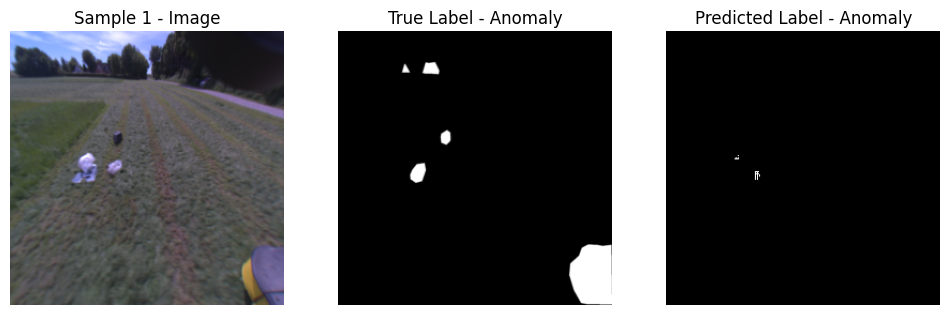

Anomaly Detected
No Anomaly Detected
Sample 2 - True Label: Anomaly
Sample 2 - Predicted Label: Normal
--------------------------------------------------


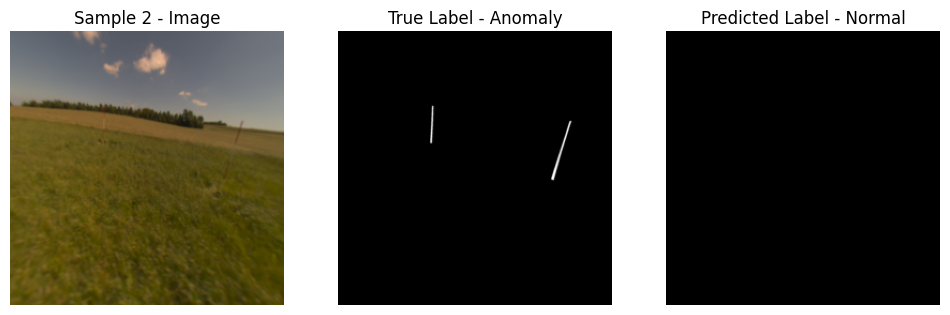

Anomaly Detected
No Anomaly Detected
Sample 3 - True Label: Anomaly
Sample 3 - Predicted Label: Normal
--------------------------------------------------


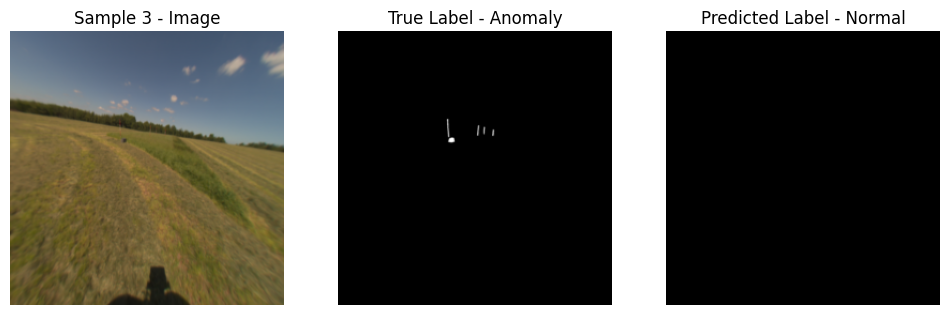

Anomaly Detected
No Anomaly Detected
Sample 4 - True Label: Anomaly
Sample 4 - Predicted Label: Normal
--------------------------------------------------


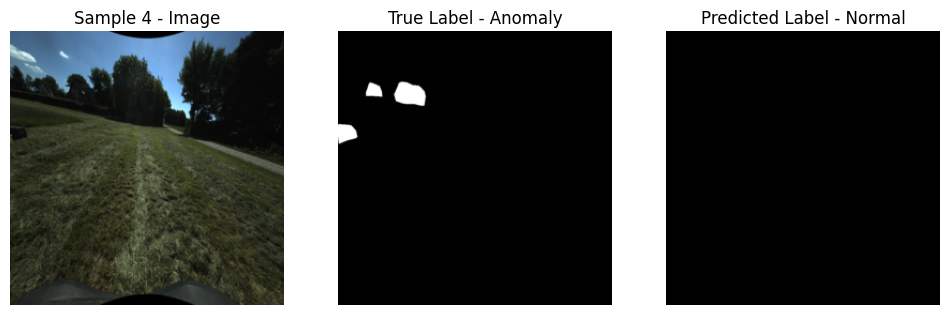

Anomaly Detected
Anomaly Detected
Sample 5 - True Label: Anomaly
Sample 5 - Predicted Label: Anomaly
--------------------------------------------------


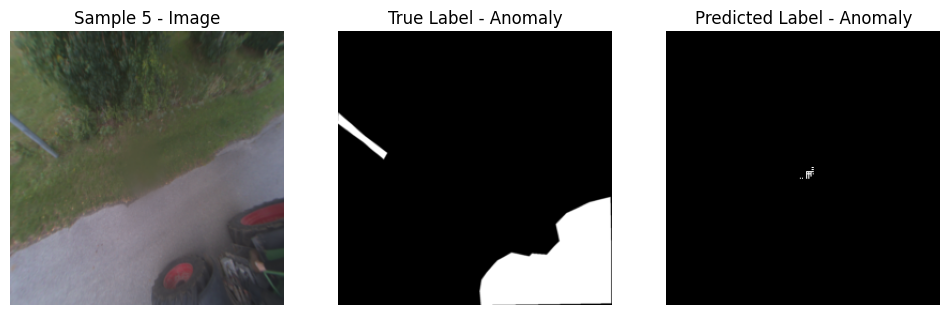

In [85]:
visualize_random_samples_with_anomalies(test_loader, model, device, num_samples=5)